# Lab 7-2: Snowpack ripening and melt initiation - Energy Balance

Written by Eli Schwat February January 2025.

In this lab, we will calculate all components of the energy balance and examine if energy balance calculations can identify the onset of melt.

This lab repeats code introduced in Labs 3-2, 4-1, and 4-2.

In [1]:
import xarray as xr
import numpy as np
import os 
import urllib
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import altair as alt

## Open data

In [2]:
# tower measurements
sos_file = "../data/sos_full_dataset_30min.nc"
sos_dataset = xr.open_dataset(sos_file)

#precip measurements
precip_file = "../data/kettle_ponds_precip.csv"
precip_dataset = pd.read_csv(precip_file)
precip_dataset['date'] = pd.to_datetime(precip_dataset['date'])
precip_dataset = precip_dataset.set_index('date').to_xarray()

In [3]:
tsnow_vars = [v for v in sos_dataset if 'Tsnow_' in v and v.endswith('_d')]
snow_depth_vars = ['SnowDepth_d']
print(snow_depth_vars, tsnow_vars)

['SnowDepth_d'] ['Tsnow_0_4m_d', 'Tsnow_0_5m_d', 'Tsnow_0_6m_d', 'Tsnow_0_7m_d', 'Tsnow_0_8m_d', 'Tsnow_0_9m_d', 'Tsnow_1_0m_d', 'Tsnow_1_1m_d', 'Tsnow_1_2m_d', 'Tsnow_1_3m_d', 'Tsnow_1_4m_d', 'Tsnow_1_5m_d']


### Extract snow temperature data for vertical profiles (repeated from Lab 4-1)

In [4]:
# Transform the NetCDF dataset to be a "tidy" dataset of snow depths
snow_temp_dataset = sos_dataset[
    tsnow_vars + snow_depth_vars
].to_dataframe().reset_index().set_index(['time', 'SnowDepth_d']).melt(ignore_index=False)

# Calculate the depth of the snow sensor (relative to the snow surface)
# using the snow depth measurements and the known above-ground height
# of the snow sensors, which is built into the variable name
snow_temp_dataset['height_agl'] = snow_temp_dataset['variable'].str[6:9].str.replace('_', '.').astype(float)
snow_temp_dataset = snow_temp_dataset.reset_index().set_index('time')
snow_temp_dataset['depth'] = snow_temp_dataset['height_agl'] - snow_temp_dataset['SnowDepth_d']

# remove measurements NOT in the snowpack
snow_temp_dataset = snow_temp_dataset.query("depth < 0")

# Add surface temperature data (depth=0)
surface_temps_dataset = sos_dataset['Tsurf_d'].to_dataframe()
surface_temps_dataset = surface_temps_dataset.rename(columns={'Tsurf_d': 'value'})
surface_temps_dataset['depth'] = 0

# Combine snow surface and in-snow temperature data
snow_temp_dataset = pd.concat([snow_temp_dataset, surface_temps_dataset])

## Calculate components of the energy balance

The snowpack energy balance equation _without_ snow melt is:

$$ \frac{d}{dt} (U \Delta z) = R_{net} - H_L - H_s + G$$

where ∆z is the snowpack depth.

### ground heat flux

In [5]:
ground_heat_flux =  sos_dataset['Gsoil_d']

### net radiation

In [6]:
net_radiation = sos_dataset['Rsw_in_9m_d'] - sos_dataset['Rsw_out_9m_d'] + sos_dataset['Rlw_in_9m_d'] - sos_dataset['Rlw_out_9m_d']

### turbulent fluxes

In [7]:
latent_heat_sublimation = 2590 #J/g
latent_heat_flux = sos_dataset['w_h2o__3m_c'] * latent_heat_sublimation

In [8]:
specific_heat_capacity_air = 1.005 # J/K/g
air_density = 1000 # g/m^3                                       
sensible_heat_flux = sos_dataset['w_tc__3m_c'] * specific_heat_capacity_air * air_density

### internal energy change

In [9]:
from metpy.units import units
rho_s = 300 * units ("kg/m^3")
c_p_ice = 2090 * units ("J/kg/K") # specific heat capacity of ice
delta_t = 30*60*units("second") # our timestep is 30 minutes

In [10]:
snow_temp_dataset_deeperthan10cm = snow_temp_dataset.query("depth <= -0.10")
# Estimate the average snowpack temperature by averaging all in-snow temperatuer measurements for each timestamp
snow_internal_energy_df = snow_temp_dataset_deeperthan10cm.groupby(
    [snow_temp_dataset_deeperthan10cm.index]
)[['value']].mean().rename(columns={
    'value': 'snowpack_temp'
})

# add snow depth to our dataset
snow_internal_energy_df = snow_internal_energy_df.join(
    sos_dataset['SnowDepth_d'].to_series()
)

# calculate depth-averaged temp and density
T_snowpack = snow_internal_energy_df['snowpack_temp'].values * units('degC')
Depth_snowpack = snow_internal_energy_df['SnowDepth_d'].values * units('meters')

# calculate dT/dt
dT_dt = np.gradient(
    snow_internal_energy_df['snowpack_temp'],
    30*60
) * units('K / second')

# calculate internal energy change term
dU_dt = rho_s * c_p_ice * Depth_snowpack * dT_dt
snow_internal_energy_df['internal_energy_change'] = dU_dt.magnitude

## Plot energy balance during snowpack ripening!

/Users/elischwat/miniforge3/envs/snow-hydrology/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


Text(0, 0.5, 'Energy flux (W/m^2)')

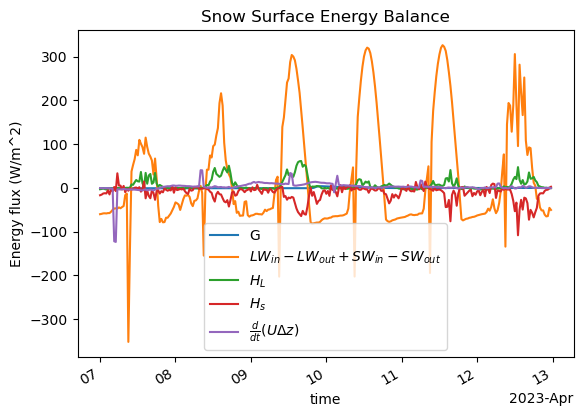

In [11]:
time_slice = slice('20230407', '20230412')
ground_heat_flux.sel(time=time_slice).plot(label=r'G')
net_radiation.sel(time=time_slice).plot(label=r'$LW_{in} - LW_{out} + SW_{in} - SW_{out}$')
latent_heat_flux.sel(time=time_slice).plot(label=r'$H_L$')
sensible_heat_flux.sel(time=time_slice).plot(label=r'$H_s$')
snow_internal_energy_df.loc[time_slice]['internal_energy_change'].plot(label=r'$\frac{d}{dt} (U \Delta z)$')
plt.legend()
plt.title('Snow Surface Energy Balance')
plt.ylabel('Energy flux (W/m^2)')

Zoom in on the snowpack internal energy storage change term

<Axes: xlabel='time'>

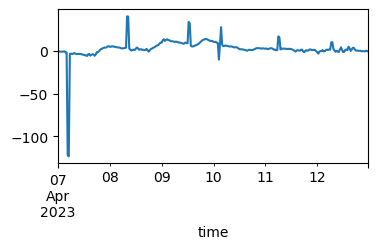

In [12]:
snow_internal_energy_df.loc[time_slice]['internal_energy_change'].plot(
    figsize=(4,2)
)

OK so it does look like the internal energy flattens out around the time of snowmelt, which is consistent with our observations of ripening using the snow temperature profiles.

We know from Lab7-1 that snowmelt started on the afternoon of the 9th, but we don't really see anything special going on in the energy balance above... What if we calculate the residual here? Part of the residual should be devoted to snowmelt, once snowmelt starts, so we expect the residual term will increase once snowmelt begins.

In [13]:
energy_residual = (
    net_radiation + ground_heat_flux + latent_heat_flux + sensible_heat_flux 
    - snow_internal_energy_df.to_xarray()['internal_energy_change']
)

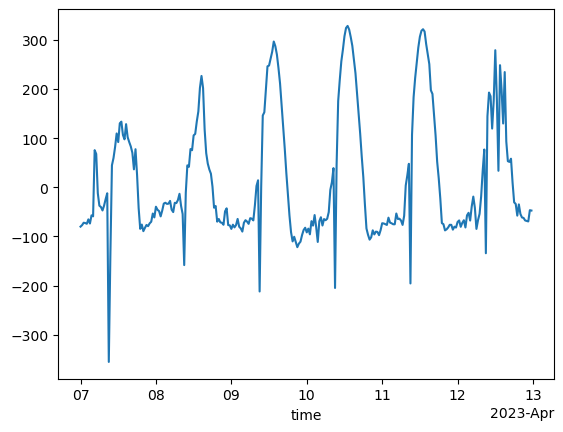

In [15]:
energy_residual.sel(time=time_slice).plot()


WE don't really see a distinct *increase* in the residual term, the residual term mostly just follows the dominant net radiation term. We do see that on April 9th, it was not very cloudy, so maybe this increased solar radiation contributed to the melt.

## Plot energy balance over larger time period.

Let's focus on the really significant terms in our energy balance. From the plot above, we see we can pretty much ignore ground heat flux and internal energy change.

Let's start looking at the radiation components separately as well.

First let's look at the days during ripening.

Text(0, 0.5, 'Energy flux (W/m^2)')

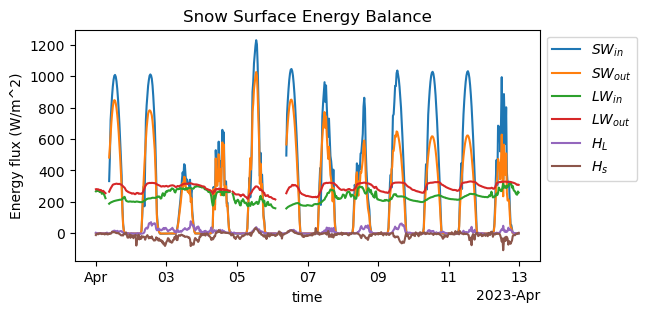

In [29]:
time_slice = slice('20230401', '20230412')
sos_dataset['Rsw_in_9m_d'].sel(time=time_slice).plot(label=r'$SW_{in}$', figsize=(6,3))
sos_dataset['Rsw_out_9m_d'].sel(time=time_slice).plot(label=r'$SW_{out}$')
sos_dataset['Rlw_in_9m_d'].sel(time=time_slice).plot(label=r'$LW_{in}$')
sos_dataset['Rlw_out_9m_d'].sel(time=time_slice).plot(label=r'$LW_{out}$')
latent_heat_flux.sel(time=time_slice).plot(label=r'$H_L$')
sensible_heat_flux.sel(time=time_slice).plot(label=r'$H_s$')
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
plt.title('Snow Surface Energy Balance')
plt.ylabel('Energy flux (W/m^2)')

We can see that albedo (SW_out / SW_in) seems to decrease quite a bit starting April 8-9. This has a big effect on increasing the residual term - see below, compare April 1--2 (sunny days) to April 8-9 (also sunny days).

Text(0, 0.5, 'Energy balance \n residual (W/m^2)')

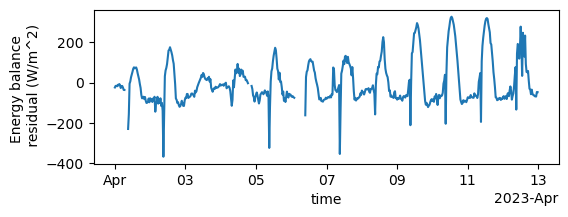

In [32]:
energy_residual.sel(time=time_slice).plot(figsize=(6,2))
plt.ylabel('Energy balance \n residual (W/m^2)')

Remember the lab when we calculated albedo? Dust was deposited on the snow at this time. So the increase in net radiation contributed significantly to the snowpack ripening process.

Let's look at just net radiation for March and April

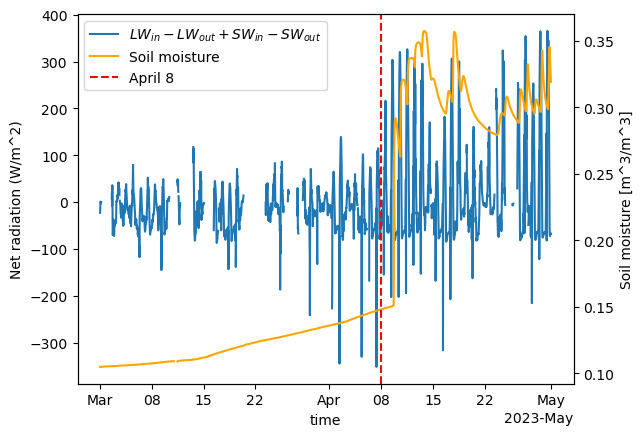

In [53]:
time_slice = slice('20230301', '20230430')
net_radiation.sel(time=time_slice).plot(label=r'$LW_{in} - LW_{out} + SW_{in} - SW_{out}$')
ax1 = plt.gca()
ax1.set_ylabel('Net radiation (W/m^2)')

sos_dataset['Qsoil_d'].sel(time=time_slice).plot(
    label='Soil moisture',
    color='orange',
    ax = plt.gca().twinx()
)
plt.axvline(x=pd.to_datetime('2023-04-08'), color='red', linestyle='--', label='April 8')
ax2 = plt.gca()

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.gca().legend(lines + lines2, labels + labels2, loc='upper left')

We see that net radiation doesn't get very large until around when the dust was deposited, the snowpack ripened, and melt began.

## Melting and Snow Pillow Measurements

In Lundquist et al. (2024), strange behavior was observed for the four snow pillows at Kettle Ponds, where SWE measurements diverged after the initiation of melt. Let's look at snow pillow SWE, soil moisture (to identify the start of melt), blowing snow flux, and precipitation to see what processes could explain differences between snow pillows. 

In [88]:
time_slice = slice('20230401', '20230430')


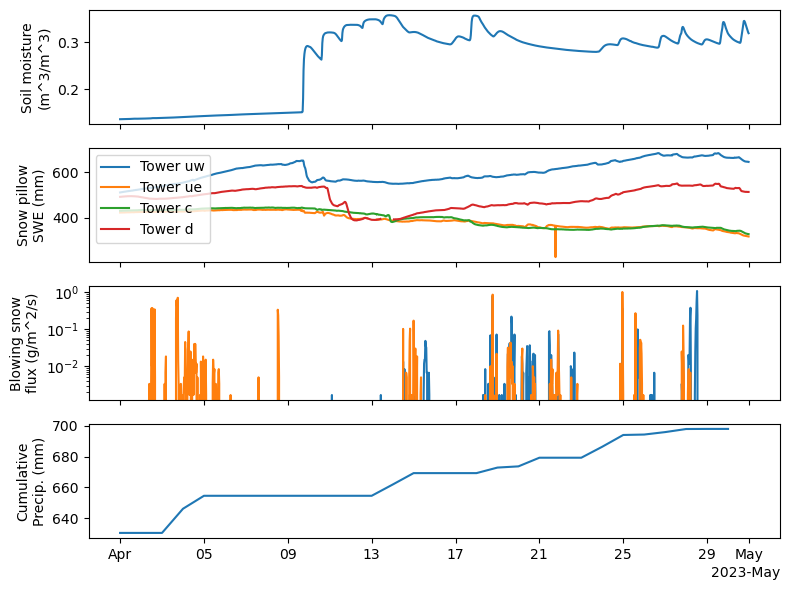

In [89]:
fig, axes = plt.subplots(4,1, figsize=(8,6), sharex=True)
sos_dataset['Qsoil_d'].sel(time=time_slice).plot(ax=axes[0])
axes[0].set_ylabel('Soil moisture\n(m^3/m^3)')
sos_dataset['SWE_p1_c'].sel(time=time_slice).plot(ax=axes[1], label='Tower uw')
sos_dataset['SWE_p2_c'].sel(time=time_slice).plot(ax=axes[1], label='Tower ue')
sos_dataset['SWE_p3_c'].sel(time=time_slice).plot(ax=axes[1], label='Tower c')
sos_dataset['SWE_p4_c'].sel(time=time_slice).plot(ax=axes[1], label='Tower d')
axes[1].set_ylabel('Snow pillow\nSWE (mm)')
axes[1].legend(loc='upper left')
sos_dataset['SF_avg_1m_ue'].sel(time=time_slice).plot(ax=axes[2])
sos_dataset['SF_avg_2m_ue'].sel(time=time_slice).plot(ax=axes[2])
axes[2].set_yscale('log')
axes[2].set_ylabel('Blowing snow\nflux (g/m^2/s)')
precip_dataset['acc_prec'].sel(date=time_slice).plot(ax=axes[3])
axes[3].set_ylabel('Cumulative\nPrecip. (mm)')
for ax in axes:
    ax.set_xlabel('')
plt.tight_layout()

We can see, as in the Lundquist et al. paper, the snow pillow SWE increases at some snow pillows (d and uw) but not at the other two. While precip could explain this, as there was some precip during the month, the fact that two of the snow pillows do not show any increases, suggests that melt water may have to do the SWE increase. 
Lundquist et al. hypothesized that "meltwater flowed through the snowpack and refroze, resulting in increasing snow water equivalent (SWE) at the UW and D snow pillows"